In [1]:
import pandas as pd
# import pandasql as ps
import matplotlib.pyplot as plt
# Import argsort
from numpy import argsort
from Functions.connection.connection import *
from Functions.AlertP1.data_cleaning import *
from Functions.AlertP1.features import *
from Functions.analysis.step_analysis import *
from Functions.AlertP1.dummy_features import *
from Functions.Models.xgboost import *
from Functions.Models.evaluation import *
from Functions.NLP.alertp1_nlp import *
from Functions.NLP.data_with_nlp import *
from Functions.pipeline import *

In [2]:
def precision_at_k(y_true, y_pred, k):
    y_true = y_true.to_numpy()
    # Get the indices of the top k predictions
    top_k_indices = np.argsort(y_pred)[-k:]
    # Get the top k predictions
    top_k_predictions = y_true[top_k_indices]
    # Calculate precision@k
    precision = np.sum(top_k_predictions) / k
    return precision

In [3]:
alertP1=connection("credentials.txt")

Tables: [('ConsultaUrgencia_doentespedidosconsultaNeurologia2012',), ('consultaneurologia2012',), ('consultaneurologia201216anon_true',), ('hgo_data_032023',)]
760


/Users/miguelcosta/Desktop/PBL/PBL-HGO-1/Functions/connection/connection.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  alertP1 = pd.read_sql("""SELECT * FROM consultaneurologia201216anon_true""",mydb)


In [4]:
data = pre_process(alertP1)

/Users/miguelcosta/Desktop/PBL/PBL-HGO-1/Functions/AlertP1/data_cleaning.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alertP1['PROVENIENCIA'][alertP1['PROVENIENCIA']=='']='unknown'
/Users/miguelcosta/Desktop/PBL/PBL-HGO-1/Functions/AlertP1/data_cleaning.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alertP1['CTH_PRIOR'][alertP1['CTH_PRIOR']=='']='unknown'
/Users/miguelcosta/Desktop/PBL/PBL-HGO-1/Functions/AlertP1/data_cleaning.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

In [67]:
eliminate_cols=['ID_DOENTE','PROCESSO','COD_REFERENCIA','result','COD_PZ','COD_UNID_SAUDE_PROV','UNID_PROV','TIPO_UNID','COD_CTH_PRIOR','CTH_PRIOR','COD_MOTIVO_RECUSA','DES_MOTIVO_RECUSA','COD_ESPECIALIDADE','DES_ESPECIALIDADE','agrupadora','OUTRA_ENTIDADE','DATA_RECEPCAO','DATA_ENVIO','DATA_RETORNO','NUM_TAXA','ESTADO','DATA_MARCACAO','DATA_REALIZACAO','OBSERVACOES','Mês_entrada','Ano_entrada','trata data recusa','resume saída','mês_saida','ano_saida','Texto','clean_text']
X = data.drop(eliminate_cols,axis=1)# Features
y = data.result # Target variable
features=X.columns

y_pred, model_score, X_train, X_test, y_train, y_test = xgb_classifier(X,y)

In [88]:
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve, auc, confusion_matrix, cohen_kappa_score

def evaluate_thresholds(y_pred, y_test, k = 211):
    #Precion@k
    def precision_at_k(y_true, y_pred, k):
        y_true = y_true.to_numpy()
        # Get the indices of the top k predictions
        top_k_indices = np.argsort(y_pred)[-k:]
        # Get the top k predictions
        top_k_predictions = y_true[top_k_indices]
        # Calculate precision@k
        precision = np.sum(top_k_predictions) / k
        return precision

    # Default threshold (0.5)
    default_threshold = 0.5
    default_y_pred_binary = (y_pred >= default_threshold).astype(int)
    default_accuracy = accuracy_score(y_test, default_y_pred_binary)
    default_recall = recall_score(y_test, default_y_pred_binary)
    default_precision = precision_score(y_test, default_y_pred_binary)
    default_precision_at_k = precision_at_k(y_test, default_y_pred_binary, k)
    
    # Define thresholds
   

    # Precision-Recall trade-off
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
    f1_scores = 2 * precision * recall / (precision + recall)
    best_index = pd.Series(f1_scores).idxmax()
    pr_threshold = thresholds[best_index]
    pr_y_pred_binary = (y_pred >= pr_threshold).astype(int)
    pr_accuracy = accuracy_score(y_test, pr_y_pred_binary)
    pr_recall = recall_score(y_test, pr_y_pred_binary)
    pr_precision = precision_score(y_test, pr_y_pred_binary)
    pr_precision_at_k = precision_at_k(y_test, pr_y_pred_binary, k)
    
    thresholds = np.linspace(0, 1, 100)

    # Balanced Accuracy
    cms = [confusion_matrix(y_test, (y_pred >= t).astype(int)) for t in thresholds]
    sensitivity = [cm[1, 1] / (cm[1, 1] + cm[1, 0]) for cm in cms]
    specificity = [cm[0, 0] / (cm[0, 0] + cm[0, 1]) for cm in cms]
    balanced_accuracy = [(s + sp) / 2 for s, sp in zip(sensitivity, specificity)]
    ba_threshold = thresholds[np.argmax(balanced_accuracy)]
    ba_y_pred_binary = (y_pred >= ba_threshold).astype(int)
    ba_accuracy = accuracy_score(y_test, ba_y_pred_binary)
    ba_recall = recall_score(y_test, ba_y_pred_binary)
    ba_precision = precision_score(y_test, ba_y_pred_binary)
    ba_precision_at_k = precision_at_k(y_test, ba_y_pred_binary,k)
    
    # Cohen's Kappa
    kappas = [cohen_kappa_score(y_test, (y_pred >= t).astype(int)) for t in thresholds]
    kappa_threshold = thresholds[np.argmax(kappas)]
    kappa_y_pred_binary = (y_pred >= kappa_threshold).astype(int)
    kappa_kappa = cohen_kappa_score(y_test, kappa_y_pred_binary)
    kappa_accuracy = accuracy_score(y_test, kappa_y_pred_binary)
    kappa_recall = recall_score(y_test, kappa_y_pred_binary)
    kappa_precision = precision_score(y_test, kappa_y_pred_binary)
    kappa_precision_at_k = precision_at_k(y_test, kappa_y_pred_binary, k)

    # Limit to K
    limit_to_k_threshold = np.sort(y_pred)[-k]
    limit_to_k_y_pred_binary = (y_pred >= limit_to_k_threshold).astype(int)
    limit_to_k_accuracy = accuracy_score(y_test, limit_to_k_y_pred_binary)
    limit_to_k_recall = recall_score(y_test, limit_to_k_y_pred_binary)
    limit_to_k_precision = precision_score(y_test, limit_to_k_y_pred_binary)
    limit_to_k_precision_at_k = precision_at_k(y_test, limit_to_k_y_pred_binary, k)
    
    # Create output dataframe
    data = {
        'Analysis': ['Default', 'Precision-Recall trade-off', 'Balanced Accuracy', "Cohen's Kappa", 'Limit to K'],
        'Threshold': [round(default_threshold, 2), round(pr_threshold, 2), round(ba_threshold, 2), round(kappa_threshold, 2), round(limit_to_k_threshold, 2)],
        'Accuracy': [round(default_accuracy, 2), round(pr_accuracy, 2), round(ba_accuracy, 2), round(kappa_accuracy, 2), round(limit_to_k_accuracy, 2)],
        'Recall': [round(default_recall, 2), round(pr_recall, 2), round(ba_recall, 2), round(kappa_recall, 2), round(limit_to_k_recall, 2)],
        'Precision': [round(default_precision, 2), round(pr_precision, 2), round(ba_precision, 2), round(kappa_precision, 2), round(limit_to_k_precision, 2)],
        'Precision@211': [round(default_precision_at_k, 2), round(pr_precision_at_k, 2), round(ba_precision_at_k, 2), round(kappa_precision_at_k, 2), round(limit_to_k_precision_at_k, 2)]
    }
    
    df = pd.DataFrame(data)
    return df




In [89]:
evaluate_thresholds(y_pred, y_test)

,Analysis,Threshold,Accuracy,Recall,Precision,Precision@211
0,Default,0.50,0.69,0.95,0.69,0.68
1,Precision-Recall trade-off,0.59,0.75,0.90,0.76,0.75
2,Balanced Accuracy,0.68,0.71,0.73,0.81,0.76
3,Cohen's Kappa,0.61,0.75,0.86,0.78,0.79
4,Limit to K,0.63,0.73,0.80,0.80,0.80


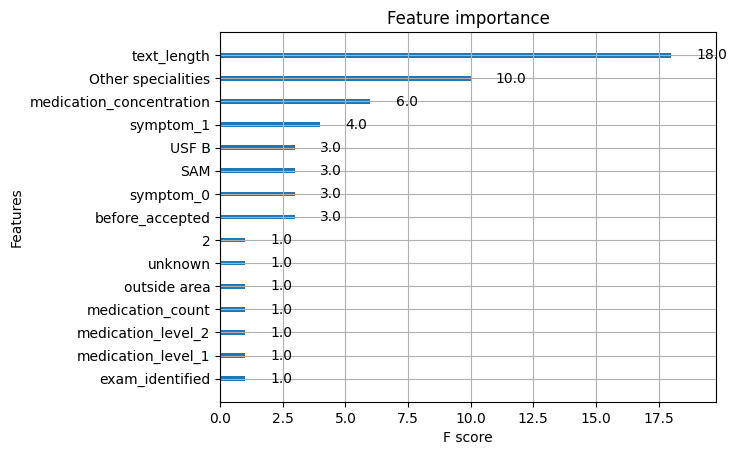

In [90]:
from xgboost import plot_importance

# Plot the feature importance scores
plot_importance(model_score)
plt.show()